# Object Tracking

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/object-tracking.ipynb)

In some cases, it's important for us to track objects across multiple frames of a video. For example, we may need to figure out the direction a vehicle is moving, or count objects in a frame. Some Supervision [Annotators](https://supervision.roboflow.com/latest/annotators/) and Tools like [LineZone](https://supervision.roboflow.com/latest/detection/tools/line_zone/) require tracking to be setup.  In this cookbook, we'll cover how to get a tracker up and running for use in your computer vision applications.

## What is a Tracker?

Trackers are a piece of code that identifies objects across frames and assigns them a unique `tracker_id`. There are a few popular trackers at the time of writing this including ByteTrack and Bot-SORT. Supervision makes using trackers a breeze and comes with ByteTrack built-in.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Feb 23 03:18:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Dependencies

In [ ]:
!pip install -q inference-gpu "supervision[assets]"

## Download a Video Asset

Now that we have our enviornment setup, lets download a video that we can detect objects in. Supervision comes with a great utility to help us hit the ground running. We can use the below snippet to he video is save a video asset in our local directory. It can also be accessed with the variable `path_to_video` for additional application logic.

In [ ]:
from supervision.assets import download_assets, VideoAssets

# Download a supervision video asset
path_to_video = download_assets(VideoAssets.PEOPLE_WALKING)

<div style="display: flex; justify-content: center;">
    <video controls width="1000"">
        <source
            src="https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
            type="video/mp4"
        >
    </video>
</div>

## Tracking Objects in a Frame

Now that we have our video installed, let's get to work on tracking objects. We'll first pull in a model from roboflow Inference to detect people in our video. Then let's create a `byte_tracker` object that we'll pass our detections to. This will give us a `tracker_id`. We'll then utilize that tracker id to label our detections with a `label_annotator` to display the tracker id.

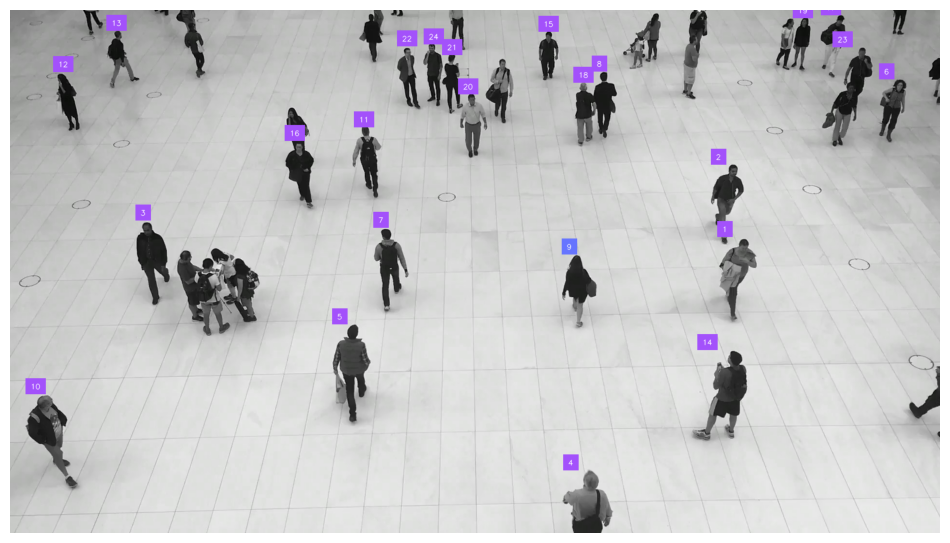

In [4]:
import supervision as sv
from inference.models.utils import get_roboflow_model

# Load a pre trained yolov8 nano model from Roboflow Inference.
model = get_roboflow_model('yolov8n-640')

# Create a video info object from the video path.
video_info = sv.VideoInfo.from_video_path(path_to_video)

# Create a label annotator for labeling detections with our tracker_id.
label = sv.LabelAnnotator()

# Create a ByteTrack object to track detections.
byte_tracker = sv.ByteTrack(frame_rate=video_info.fps)

# Create a frame generator from video path for iteration of frames.
frame_generator = sv.get_video_frames_generator(path_to_video)

# Grab a frame from the frame_generator.
frame = next(frame_generator)

# Run inference on the frame by passing it to our model.
result = model.infer(frame)[0]

# Convert model results to a supervision detection object.
detections = sv.Detections.from_inference(result)

# Update detections with tracker ids fro byte_tracker.
tracked_detections = byte_tracker.update_with_detections(detections)

# Create labels with tracker_id for label annotator.
labels = [ f"{tracker_id}" for tracker_id in tracked_detections.tracker_id ]

# Apply label annotator to frame.
annotated_frame = label.annotate(scene=frame.copy(), detections=tracked_detections, labels=labels)

# Display the frame.
sv.plot_image(annotated_frame)

## Tracking Objects in a Video

Finally, we'll use a utility called `VideoSink` to save the annotated frames to a video. Let's dive in to the code.

In [ ]:
from tqdm import tqdm

# Load a pre trained yolov8 nano model from Roboflow Inference.
model = get_roboflow_model('yolov8n-640')

# Create a video info object from the video path.
video_info = sv.VideoInfo.from_video_path(path_to_video)

# Create a label annotator for labeling detections with our tracker_id.
label = sv.LabelAnnotator()

# Create a ByteTrack object to track detections.
byte_tracker = sv.ByteTrack(frame_rate=video_info.fps)

# Create a frame generator from video path for iteration of frames.
frame_generator = sv.get_video_frames_generator(path_to_video)

# Create a video sink context manager to save resulting video.
with sv.VideoSink(target_path="output.mp4", video_info=video_info) as sink:

    # Iterate through frames yielded from the frame_generator.
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run inference on the frame by passing it to our model.
        result = model.infer(frame)[0]

        # Convert model results to a supervision detection object.
        detections = sv.Detections.from_inference(result)

        # Update detections with tracker ids fro byte_tracker.
        tracked_detections = byte_tracker.update_with_detections(detections)

        # Create labels with tracker_id for label annotator.
        labels = [ f"{tracker_id}" for tracker_id in tracked_detections.tracker_id ]

        # Apply label annotator to frame.
        annotated_frame = label.annotate(scene=frame.copy(), detections=tracked_detections, labels=labels)

        # Save the annotated frame to an output video.
        sink.write_frame(frame=annotated_frame)

Let's take a look at our resulting video. It will also be created in your current directory with the name `output.mp4` Notice how even with a little flicker, we can see the `tracker_id` on the people walking in the video. With trackers under your belt, there are now a wide variety of use cases you can solve for! Happy building!

<div style="display: flex; justify-content: center;">
  <video controls width="1000">
      <source
          src="https://media.roboflow.com/supervision/cookbooks/object-tracking.mp4"
          type="video/mp4"
      >
  </video>
</div>